In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [9]:
# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 6
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
MODEL_SAVE_PATH = "models/waste_classifier.h5"
PLOTS_SAVE_DIR = "plots"

In [10]:
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def load_data():
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True)

    train_gen = datagen.flow_from_directory(
        TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    val_gen = datagen.flow_from_directory(
        VAL_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    return train_gen, val_gen

def plot_training_history(history, title_suffix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {title_suffix}')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {title_suffix}')

    plt.tight_layout()

    if not os.path.exists(PLOTS_SAVE_DIR):
        os.makedirs(PLOTS_SAVE_DIR)
    plot_filename = f"training_history{title_suffix.replace(' ', '_').lower()}.png"
    plot_path = os.path.join(PLOTS_SAVE_DIR, plot_filename)
    plt.savefig(plot_path)
    print(f"Training plots saved at {plot_path}")
    plt.show()

Found 12000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.6484 - loss: 0.9629 - val_accuracy: 0.8220 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 365s 973ms/step - accuracy: 0.8142 - loss: 0.5207 - val_accuracy: 0.8513 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.8517 - loss: 0.4230 - val_accuracy: 0.8660 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.8639 - loss: 0.3666 - val_accuracy: 0.8720 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 362s 967ms/step - accuracy: 0.8854 - loss: 0.3239 - val_accuracy: 0.8817 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 360s 960ms/step - accuracy: 0.8937 - loss: 0.2942 - val_accuracy: 0.8893 - val_loss: 0.3342 - learning_r

Model saved at models/waste_classifier.h5
Training plots saved at plots\training_historytraining.png


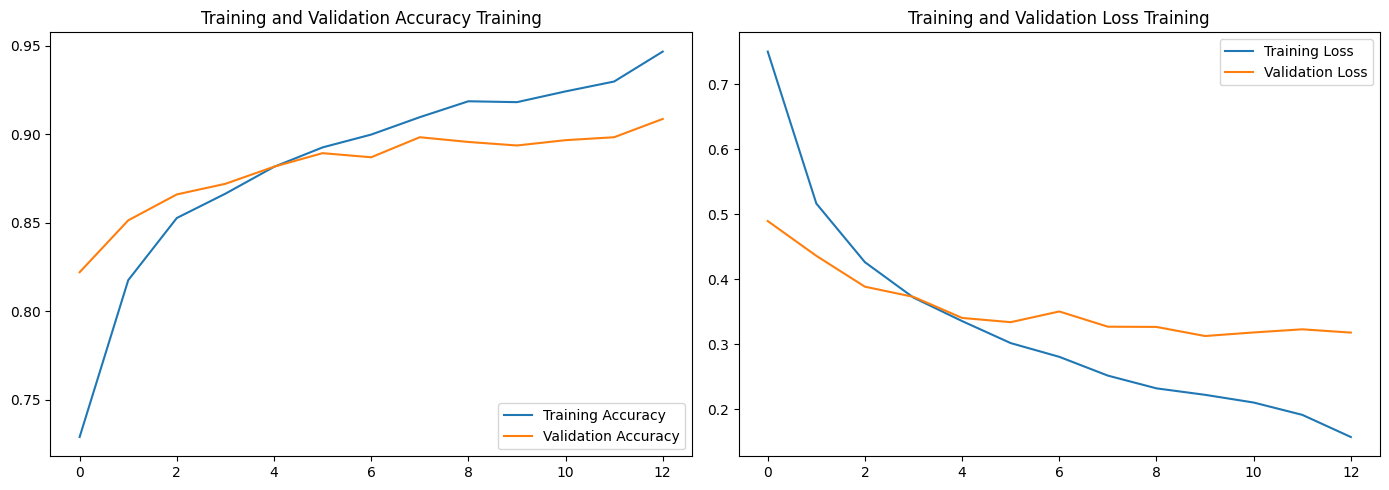

In [11]:
if __name__ == "__main__":
    train_gen, val_gen = load_data()

    model = create_model()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr]
    )

    if not os.path.exists(os.path.dirname(MODEL_SAVE_PATH)):
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH))
    model.save(MODEL_SAVE_PATH)
    print(f"Model saved at {MODEL_SAVE_PATH}")

    plot_training_history(history, title_suffix="Training")